## Problema

In [ ]:
GRAPH = (
    (0, 2, 8, 5),
    (2, 0, 3, 4),
    (8, 3, 0, 7),
    (5, 3, 7, 0)
)

NON_ADJACENT_WEIGHT = 20

def f(chromossome):
    route = Chromossome.get_fenotype(chromossome.get_genes())

    total_weight = 0
    total_vertex = len(GRAPH)

    for i in range(total_vertex):
        vertex = route[i]
        next_vertex = route[i + 1]

        edge_weight = GRAPH[vertex][next_vertex]

        if edge_weight is None:
            edge_weight = NON_ADJACENT_WEIGHT

        total_weight += edge_weight

    return total_weight

def g(chromossome):
    return 1 / (f(chromossome) + 1)

def f_average(population):
    avg = 0

    for chr in population:
        avg += f(chr)

    avg /= len(population)
    return avg

def g_average(population):
    avg = 0

    for chr in population:
        avg += g(chr)

    avg /= len(population)
    return avg    


## Chromossome

In [ ]:
import random

class Chromossome:
    def __init__(self, route = None):
        genes = route
        genes_length = len(GRAPH) - 1

        if genes is None:
            aux = [i + 1 for i in range(genes_length)]
            genes = random.sample(aux, genes_length)
        else:
            genes = Chromossome.get_genotype(route)

        self.__genes = genes

    def get_genes(self):
        return self.__genes

    def set_genes(self, genes):
        self.__genes = genes

    def to_string(self):
        chr_str = "G = [" + ", ".join(map(str, self.__genes)) + "], F = [" + ", ".join(map(str, Chromossome.get_fenotype(self.__genes))) + "]"
        return chr_str

    @staticmethod
    def get_genotype(route):
        return route[1:len(GRAPH)]

    @staticmethod
    def get_fenotype(genes):
        total_vertex = len(GRAPH)

        route = [0] * (total_vertex + 1)
        route[1:total_vertex] = genes

        return route
    

## Operators

In [ ]:
K_TOURNAMENT = 3
MUTATION_PROBABILITY = 1.00

import random

def selection(population):
    # Tournament selection without selective pressure

    parents = []
    while len(parents) != 2:
        tournament_individuals = []

        for _ in range(K_TOURNAMENT):
            individual = random.choice(population)

            if not individual in tournament_individuals:
                tournament_individuals.append(individual)

        parent = parent_fitness = None
        for individual in tournament_individuals:
            individual_fitness = g(individual)

            if parent is None or individual_fitness > parent_fitness:
                parent = individual
                parent_fitness = individual_fitness

        if parent not in parents:
            parents.append(parent)

    print(f"1st parent chosen for crossover: {format_chromossome(parents[0])}")
    print(f"2nd parent chosen for crossover: {format_chromossome(parents[1])}")

    return parents

def crossover(population, parent1, parent2):
    # Order crossover
    # http://mat.uab.cat/~alseda/MasterOpt/GeneticOperations.pdf

    parent1_genes = parent1.get_genes()
    parent2_genes = parent2.get_genes()

    genes_length = len(parent1_genes)

    child1_genes = [None] * genes_length
    child2_genes = [None] * genes_length

    parent1_subset_start = random.randint(0, genes_length - 1)
    parent2_subset_start = random.randint(0, genes_length - 1)

    parent1_subset_end = random.randint(parent1_subset_start + 1, genes_length)
    parent2_subset_end = random.randint(parent2_subset_start + 1, genes_length)

    print(f"1st parent subset indexes: {parent1_subset_start} (inclusive) to {parent1_subset_end} (exclusive)")
    print(f"2nd parent subset indexes: {parent2_subset_start} (inclusive) to {parent2_subset_end} (exclusive)")

    child1_genes[parent1_subset_start:parent1_subset_end] = parent1_genes[parent1_subset_start:parent1_subset_end]
    child2_genes[parent2_subset_start:parent2_subset_end] = parent2_genes[parent2_subset_start:parent2_subset_end]

    parent1_next_index = parent2_next_index = 0
    for i in range(genes_length):
        if child1_genes[i] is None:
            for k in range(parent2_next_index, genes_length):
                gene = parent2_genes[k]
                if gene in child1_genes:
                    continue
    
                child1_genes[i] = gene
                parent2_next_index = k + 1

                break

        if child2_genes[i] is None:
            for k in range(parent1_next_index, genes_length):
                gene = parent1_genes[k]
                if gene in child2_genes:
                    continue

                child2_genes[i] = gene
                parent1_next_index = k + 1

                break
                
    child1 = Chromossome()
    child1.set_genes(child1_genes)
    print(f"1st child generated from crossover: {format_chromossome(child1)}")

    child2 = Chromossome()
    child2.set_genes(child2_genes)
    print(f"2nd child generated from crossover: {format_chromossome(child2)}")

    population.append(child1)
    population.append(child2)

def mutation(population):
    # Swap mutation (avoid illegal genotype)

    prob = random.uniform(0, 1)

    if prob >= MUTATION_PROBABILITY:
        return

    target = random.choice(population)

    genes = target.get_genes()

    genes_length = len(genes)

    mutation_point_1 = mutation_point_2 = -1
    while mutation_point_1 == mutation_point_2:
        mutation_point_1 = random.choice(range(genes_length))
        mutation_point_2 = random.choice(range(genes_length))

    print(f"Invididual {target.to_string()} will mutate at points ({mutation_point_1}, {mutation_point_2})")

    genes[mutation_point_1], genes[mutation_point_2] = genes[mutation_point_2], genes[mutation_point_1]

    print(f"Individual {target.to_string()} mutated at points ({mutation_point_1}, {mutation_point_2})")

def elitism(population):
    for _ in range(2):
        worst_individual = find_worst_chromossome(population)
        print(f"Removing worst individual from population: {format_chromossome(worst_individual)}")
        population.remove(worst_individual)

## Utils

In [ ]:
def find_best_chromossome(population):
    best_chromossome = None

    for chromossome in population:
        score = g(chromossome)

        if best_chromossome is None or score > g(best_chromossome):
            best_chromossome = chromossome

    return best_chromossome

def find_worst_chromossome(population):
    worst_chromossome = None

    for chromossome in population:
        score = g(chromossome)

        if worst_chromossome is None or score < g(worst_chromossome):
            worst_chromossome = chromossome

    return worst_chromossome

def format_chromossome(chromossome):
    return f"{chromossome.to_string()}, Score = {g(chromossome):.3f}"

## Main

Generation # 0 -> Average population score = 0.051

1st parent chosen for crossover: G = [2, 3, 1], F = [0, 2, 3, 1, 0], Score = 0.048
2nd parent chosen for crossover: G = [1, 2, 3], F = [0, 1, 2, 3, 0], Score = 0.056
1st parent subset indexes: 1 (inclusive) to 2 (exclusive)
2nd parent subset indexes: 0 (inclusive) to 3 (exclusive)
1st child generated from crossover: G = [1, 3, 2], F = [0, 1, 3, 2, 0], Score = 0.045
2nd child generated from crossover: G = [1, 2, 3], F = [0, 1, 2, 3, 0], Score = 0.056
Removing worst individual from population: G = [1, 3, 2], F = [0, 1, 3, 2, 0], Score = 0.045
Removing worst individual from population: G = [1, 3, 2], F = [0, 1, 3, 2, 0], Score = 0.045
Generation # 1 -> Average population score = 0.052

1st parent chosen for crossover: G = [1, 2, 3], F = [0, 1, 2, 3, 0], Score = 0.056
2nd parent chosen for crossover: G = [1, 2, 3], F = [0, 1, 2, 3, 0], Score = 0.056
1st parent subset indexes: 1 (inclusive) to 2 (exclusive)
2nd parent subset indexes: 0 (in

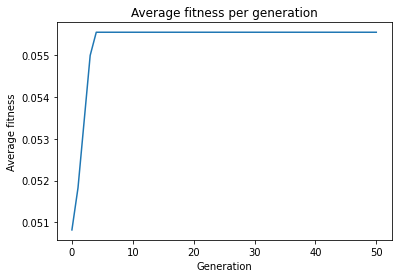

In [ ]:
import matplotlib.pyplot as plt


if __name__ == "__main__":
    population = [Chromossome() for _ in range(10)]

    generation = 0
    population_score = g_average(population)
    print(f"Generation # {generation} -> Average population score = {population_score:.3f}\n")

    generation_plot = []
    generation_plot.append(generation)

    population_score_plot = []
    population_score_plot.append(population_score)

    while generation < 50:
        parent1, parent2 = selection(population)

        crossover(population, parent1, parent2)
        mutation(population)
        elitism(population)

        generation += 1
        population_score = g_average(population)

        generation_plot.append(generation)
        population_score_plot.append(population_score)

        print(f"Generation # {generation} -> Average population score = {population_score:.3f}\n")

        if generation <= 40:
            # Start with a high mutation rate to cover a lot of the solution space and then cool
            # it down to better optimize local optima.
            # 100% -> 5% in 40 generations
            # Keep 5% until last generation
            
            MUTATION_PROBABILITY -= 2.375

    best_chromossome = find_best_chromossome(population)
    print(f"Best individual: {format_chromossome(best_chromossome)}")
    
    plt.gca().set_xlabel("Generation")
    plt.gca().set_ylabel("Average fitness")
    plt.gca().set_title("Average fitness per generation")
    plt.plot(generation_plot, population_score_plot)
    plt.show()